In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

source: http://www.bom.gov.au/climate/data/

In [4]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


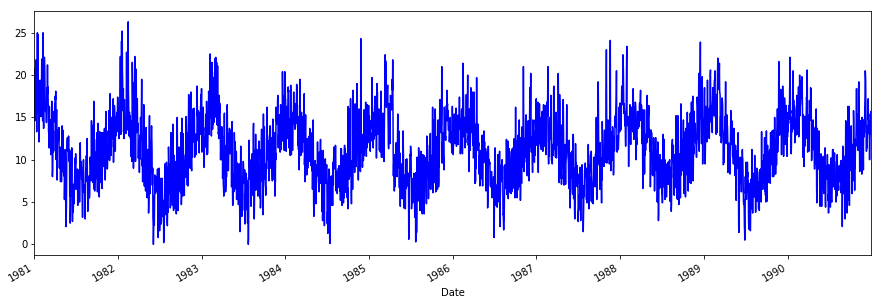

In [5]:
df.Temp.plot(figsize=(15, 5), color='b')

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Prepare Sequence

In [7]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [19]:
seq_len = 50
truncation = 5
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len, trunc_len=truncation)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len, trunc_len=truncation)
testloader = DataLoader(train_set, batch_size=bs)

(N, T, S, F): (58, 10, 5, 1)
Note: last 19 data excluded

(N, T, S, F): (14, 10, 5, 1)
Note: last 29 data excluded



# Arsitektur & Config

In [20]:
from jcopdl.layers import linear_block

In [21]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):        
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [22]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "truncation": train_set.n_truncate,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation -> MCOC

In [23]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/rnn')

# Training


Epoch     1
Train_cost  = 953.9321 | Test_cost  = 2436.2644 | 

Epoch     2
Train_cost  = 483.3067 | Test_cost  = 1608.9007 | 

Epoch     3
Train_cost  = 339.9773 | Test_cost  = 1189.9868 | 

Epoch     4
Train_cost  = 258.5350 | Test_cost  = 941.6820 | 

Epoch     5
Train_cost  = 211.3864 | Test_cost  = 803.7589 | 

Epoch     6
Train_cost  = 185.9056 | Test_cost  = 732.8614 | 

Epoch     7
Train_cost  = 173.1638 | Test_cost  = 699.3766 | 

Epoch     8
Train_cost  = 167.2872 | Test_cost  = 684.8689 | 

Epoch     9
Train_cost  = 164.7740 | Test_cost  = 679.0535 | 

Epoch    10
Train_cost  = 163.7557 | Test_cost  = 676.8228 | 

Epoch    11
Train_cost  = 163.3411 | Test_cost  = 675.9076 | 

Epoch    12
Train_cost  = 163.1441 | Test_cost  = 675.3726 | 

Epoch    13
Train_cost  = 162.9986 | Test_cost  = 674.7557 | 

Epoch    14
Train_cost  = 162.7788 | Test_cost  = 673.2712 | 

Epoch    15
Train_cost  = 162.0444 | Test_cost  = 665.6935 | 

Epoch    16
Train_cost  = 153.4199 | Test_cost  = 5

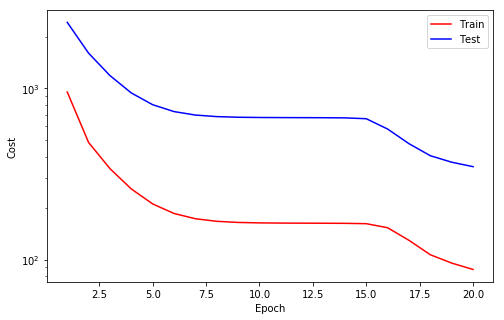


Epoch    21
Train_cost  = 83.2371 | Test_cost  = 332.4090 | 

Epoch    22
Train_cost  = 79.3354 | Test_cost  = 318.7810 | 

Epoch    23
Train_cost  = 76.9303 | Test_cost  = 312.4045 | 

Epoch    24
Train_cost  = 75.4151 | Test_cost  = 300.1592 | 

Epoch    25
Train_cost  = 72.7347 | Test_cost  = 296.4636 | 

Epoch    26
Train_cost  = 70.7535 | Test_cost  = 291.0990 | 

Epoch    27
Train_cost  = 70.9764 | Test_cost  = 307.0014 | 
==> EarlyStop patience =  1 | Best test_cost: 291.0990

Epoch    28
Train_cost  = 75.4721 | Test_cost  = 315.0506 | 
==> EarlyStop patience =  2 | Best test_cost: 291.0990

Epoch    29
Train_cost  = 70.4523 | Test_cost  = 286.1835 | 

Epoch    30
Train_cost  = 69.0587 | Test_cost  = 285.3720 | 

Epoch    31
Train_cost  = 67.9758 | Test_cost  = 276.4167 | 

Epoch    32
Train_cost  = 66.8921 | Test_cost  = 279.5843 | 
==> EarlyStop patience =  1 | Best test_cost: 276.4167

Epoch    33
Train_cost  = 66.5692 | Test_cost  = 273.9370 | 

Epoch    34
Train_cost  = 66

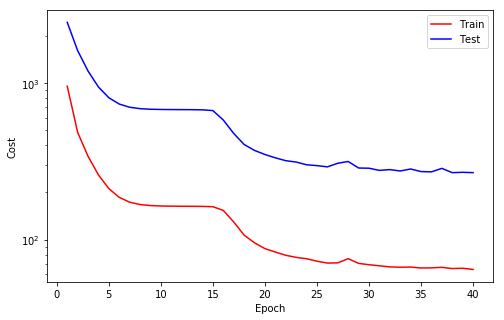

==> EarlyStop patience =  2 | Best test_cost: 267.3264

Epoch    41
Train_cost  = 64.4502 | Test_cost  = 264.6002 | 

Epoch    42
Train_cost  = 65.0585 | Test_cost  = 277.0567 | 
==> EarlyStop patience =  1 | Best test_cost: 264.6002

Epoch    43
Train_cost  = 63.8682 | Test_cost  = 262.4692 | 

Epoch    44
Train_cost  = 64.3453 | Test_cost  = 265.4855 | 
==> EarlyStop patience =  1 | Best test_cost: 262.4692

Epoch    45
Train_cost  = 63.3887 | Test_cost  = 262.9918 | 
==> EarlyStop patience =  2 | Best test_cost: 262.4692

Epoch    46
Train_cost  = 63.4436 | Test_cost  = 260.6074 | 

Epoch    47
Train_cost  = 64.0103 | Test_cost  = 271.4444 | 
==> EarlyStop patience =  1 | Best test_cost: 260.6074

Epoch    48
Train_cost  = 62.9711 | Test_cost  = 259.5128 | 

Epoch    49
Train_cost  = 63.5370 | Test_cost  = 262.4740 | 
==> EarlyStop patience =  1 | Best test_cost: 259.5128

Epoch    50
Train_cost  = 62.7404 | Test_cost  = 260.6031 | 
==> EarlyStop patience =  2 | Best test_cost: 259.

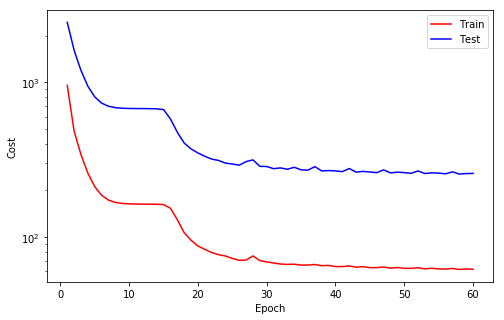

==> EarlyStop patience =  2 | Best test_cost: 255.1713

Epoch    61
Train_cost  = 61.5824 | Test_cost  = 254.2482 | 

Epoch    62
Train_cost  = 62.1947 | Test_cost  = 260.3760 | 
==> EarlyStop patience =  1 | Best test_cost: 254.2482

Epoch    63
Train_cost  = 61.2851 | Test_cost  = 253.3806 | 

Epoch    64
Train_cost  = 61.6704 | Test_cost  = 253.8650 | 
==> EarlyStop patience =  1 | Best test_cost: 253.3806

Epoch    65
Train_cost  = 61.6174 | Test_cost  = 257.2937 | 
==> EarlyStop patience =  2 | Best test_cost: 253.3806

Epoch    66
Train_cost  = 61.0829 | Test_cost  = 252.4167 | 

Epoch    67
Train_cost  = 61.7725 | Test_cost  = 256.5715 | 
==> EarlyStop patience =  1 | Best test_cost: 252.4167

Epoch    68
Train_cost  = 60.9672 | Test_cost  = 252.2606 | 

Epoch    69
Train_cost  = 61.0879 | Test_cost  = 251.3578 | 

Epoch    70
Train_cost  = 61.5736 | Test_cost  = 257.6275 | 
==> EarlyStop patience =  1 | Best test_cost: 251.3578

Epoch    71
Train_cost  = 60.6641 | Test_cost  = 

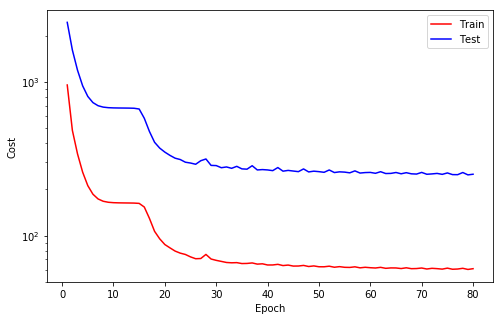

==> EarlyStop patience =  1 | Best test_cost: 248.3154

Epoch    81
Train_cost  = 60.3817 | Test_cost  = 249.7563 | 
==> EarlyStop patience =  2 | Best test_cost: 248.3154

Epoch    82
Train_cost  = 60.1519 | Test_cost  = 247.8070 | 

Epoch    83
Train_cost  = 61.0961 | Test_cost  = 256.5935 | 
==> EarlyStop patience =  1 | Best test_cost: 247.8070

Epoch    84
Train_cost  = 59.9413 | Test_cost  = 245.8767 | 

Epoch    85
Train_cost  = 60.3753 | Test_cost  = 247.4043 | 
==> EarlyStop patience =  1 | Best test_cost: 245.8767

Epoch    86
Train_cost  = 60.1511 | Test_cost  = 249.6486 | 
==> EarlyStop patience =  2 | Best test_cost: 245.8767

Epoch    87
Train_cost  = 59.7675 | Test_cost  = 246.0214 | 
==> EarlyStop patience =  3 | Best test_cost: 245.8767

Epoch    88
Train_cost  = 60.6417 | Test_cost  = 254.5702 | 
==> EarlyStop patience =  4 | Best test_cost: 245.8767

Epoch    89
Train_cost  = 59.5502 | Test_cost  = 243.8082 | 

Epoch    90
Train_cost  = 59.8772 | Test_cost  = 245.225

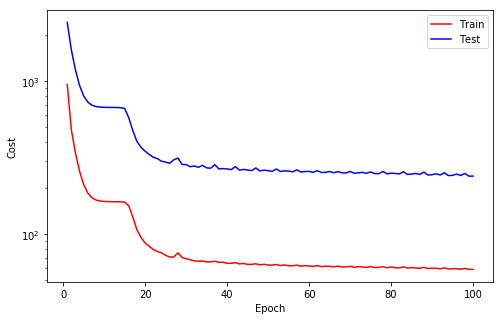

==> EarlyStop patience =  1 | Best test_cost: 239.6419

Epoch   101
Train_cost  = 59.2585 | Test_cost  = 247.6571 | 
==> EarlyStop patience =  2 | Best test_cost: 239.6419

Epoch   102
Train_cost  = 58.6459 | Test_cost  = 240.0097 | 
==> EarlyStop patience =  3 | Best test_cost: 239.6419

Epoch   103
Train_cost  = 59.1137 | Test_cost  = 247.1009 | 
==> EarlyStop patience =  4 | Best test_cost: 239.6419

Epoch   104
Train_cost  = 58.4084 | Test_cost  = 237.4356 | 

Epoch   105
Train_cost  = 58.3070 | Test_cost  = 237.6639 | 
==> EarlyStop patience =  1 | Best test_cost: 237.4356

Epoch   106
Train_cost  = 58.9912 | Test_cost  = 247.0073 | 
==> EarlyStop patience =  2 | Best test_cost: 237.4356

Epoch   107
Train_cost  = 58.3667 | Test_cost  = 237.8722 | 
==> EarlyStop patience =  3 | Best test_cost: 237.4356

Epoch   108
Train_cost  = 58.6049 | Test_cost  = 246.4615 | 
==> EarlyStop patience =  4 | Best test_cost: 237.4356

Epoch   109
Train_cost  = 58.0875 | Test_cost  = 234.9898 | 

E

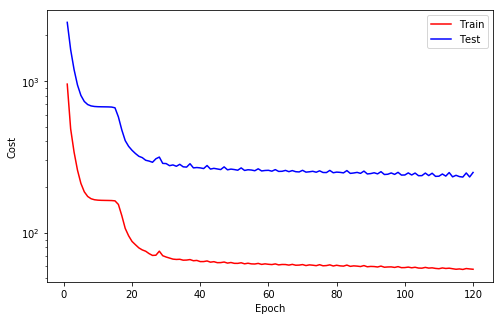

==> EarlyStop patience =  3 | Best test_cost: 232.5298

Epoch   121
Train_cost  = 57.1739 | Test_cost  = 230.3222 | 

Epoch   122
Train_cost  = 56.4454 | Test_cost  = 241.4569 | 
==> EarlyStop patience =  1 | Best test_cost: 230.3222

Epoch   123
Train_cost  = 56.6593 | Test_cost  = 229.2118 | 

Epoch   124
Train_cost  = 56.0324 | Test_cost  = 229.5039 | 
==> EarlyStop patience =  1 | Best test_cost: 229.2118

Epoch   125
Train_cost  = 56.8935 | Test_cost  = 241.3459 | 
==> EarlyStop patience =  2 | Best test_cost: 229.2118

Epoch   126
Train_cost  = 56.8152 | Test_cost  = 230.6773 | 
==> EarlyStop patience =  3 | Best test_cost: 229.2118

Epoch   127
Train_cost  = 57.0032 | Test_cost  = 249.0977 | 
==> EarlyStop patience =  4 | Best test_cost: 229.2118

Epoch   128
Train_cost  = 56.9351 | Test_cost  = 229.7298 | 
==> EarlyStop patience =  5 | Best test_cost: 229.2118
==> Execute Early Stopping at epoch: 128 | Best test_cost: 229.2118
==> Best model is saved at model/rnn


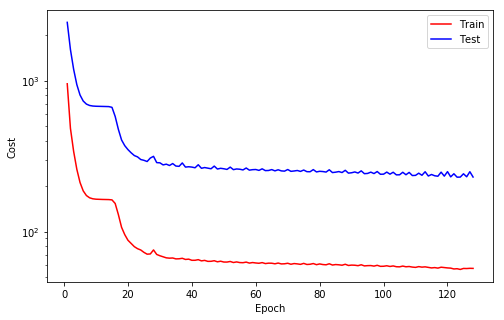

In [24]:
while True:    
    ## Training ##
    model.train()
    cost = 0
    for inputs, targets in trainloader:
        hidden = None        
        for step in range(inputs.shape[1]):
            input_step, target_step = inputs[:, step, :, :].to(device), targets[:, step, :, :].to(device)

            output, hidden = model(input_step, hidden)
            loss = criterion(output, target_step)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            hidden.detach_()

            cost += loss.item() * input_step.shape[0]
    train_cost = cost / len(train_set)
    
    ## Testing ##
    with torch.no_grad():
        model.eval()
        cost = 0
        for inputs, targets in testloader:
            hidden = None        
            for step in range(inputs.shape[1]):
                input_step, target_step = inputs[:, step, :, :].to(device), targets[:, step, :, :].to(device)            

                output, hidden = model(input_step, hidden)
                loss = criterion(output, target_step)

                cost += loss.item() * input_step.shape[0]
        test_cost = cost / len(test_set)

    ## Callback ##
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()        
        break

# Load Best Model

In [25]:
weights = torch.load("model/rnn/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)

<All keys matched successfully>

# Forecast

In [26]:
from utils import data4pred, pred4pred

In [27]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

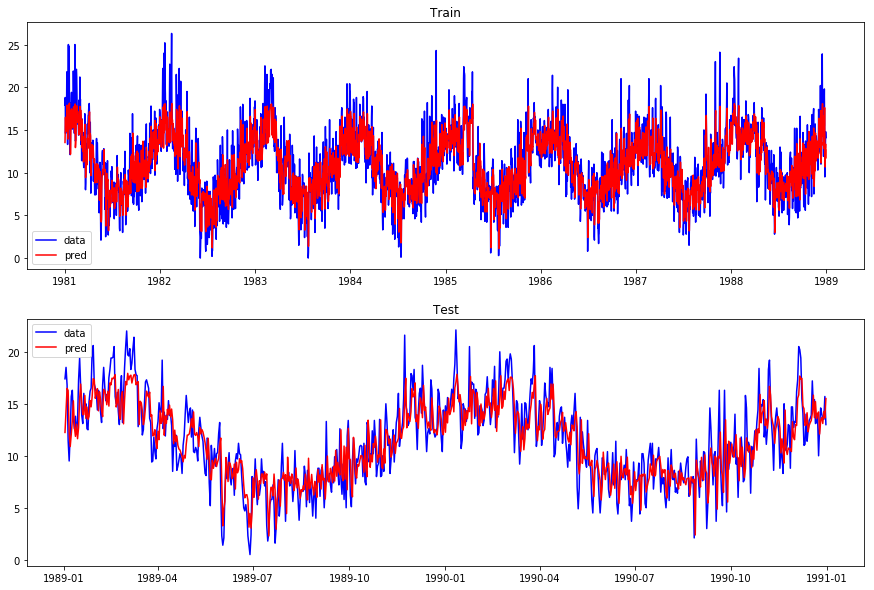

In [28]:
plt.figure(figsize=(15, 10))
    
plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

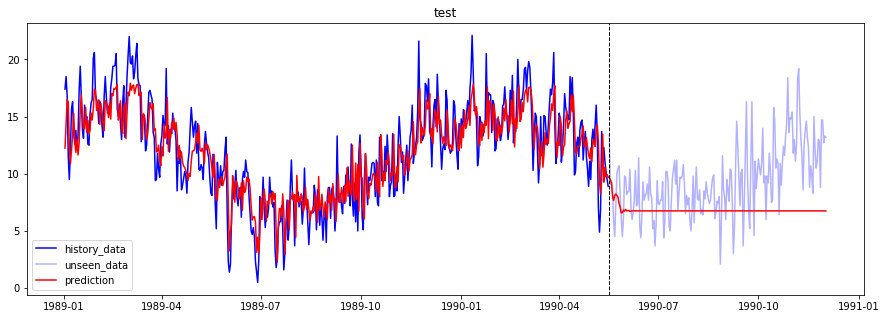

In [29]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test");